In [85]:
from pyzabbix import ZabbixAPI
import pandas as pd
import re
import pytz
import datetime
import time
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
load_dotenv()

True

In [28]:
#--------------  connected PG ----------------#
system_info_config = {
    'host' : os.environ.get("SYSTEM_INFO_HOST"),
    'port' : os.environ.get("SYSTEM_INFO_PORT"),
    'user' : os.environ.get("SYSTEM_INFO_USER"),
    'password' : os.environ.get("SYSTEM_INFO_PASS"),
    'database' : os.environ.get("SYSTEM_INFO_DB")
}
print(system_info_config)

db_connection_url = f"postgresql://{system_info_config['user']}:{system_info_config['password']}@{system_info_config['host']}:{system_info_config['port']}/{system_info_config['database']}"
conn = create_engine(db_connection_url)
sql = "select * from server_info"
df_sever_info = pd.read_sql_query(sql, conn)
df_sever_info

{'host': '10.10.10.200', 'port': '5432', 'user': 'system', 'password': 'FJNCEHfV', 'database': 'system'}


,server_name,ip_address,hostname,server_type,operating_system,services_software,cpu_total,cpu_unit,memory_total,memory_unit,disk_total,disk_unit
0,360-Webserver-01,10.10.10.22,web1.bigdata.local,Virtual Server,Ubuntu 20.04 LTS,"Frontend , Nginx",8,core,8,GB,250,GB
1,360-Webserver-02,10.10.10.23,web2.bigdata.local,Virtual Server,Ubuntu 20.04 LTS,"Frontend , Nginx",8,core,8,GB,250,GB
2,Big Data Data node 1,10.10.10.14,cdhdn1.bigdata.local,Physical Server,Centos 7.9,"DataNode, Impala",24,core,128,GB,12,TB
3,Big Data Data Node 2,10.10.10.15,cdhdn2.bigdata.local,Physical Server,Centos 7.9,"DataNode, Impala",24,core,128,GB,12,TB
4,Big Data Data Node 3,10.10.10.16,cdhdn3.bigdata.local,Physical Server,Centos 7.9,"DataNode, Impala",24,core,128,GB,12,TB
5,CDH6-Master-Node-1,10.10.10.200,cdhmn1.bigdata.local,Virtual Server,Centos 7.9,"CM, Hue, Atlas, Ranger, Hive",16,core,64,GB,250,GB


In [66]:
#example 
from itsdangerous import URLSafeSerializer
from itsdangerous.serializer import Serializer
from cryptography.fernet import Fernet
key = Fernet.generate_key() #this is your "password"

zapi = ZabbixAPI("http://10.10.10.20/zabbix")
#hosts = zapi.host.get() #method host.get for hostid and hostname

#s = URLSafeSerializer(key)
s = Serializer(key)
#encoded = s.dumps(hosts)
encoded = s.dumps(zapi.host.get())
decoded = s.loads(encoded)

In [52]:
#--------------  Hostname/Hostid ----------------#
zapi = ZabbixAPI("http://10.10.10.20/zabbix")
hosts = zapi.host.get() #method host.get for hostid and hostname
#get host_id, host_ip and host_name
df_host = pd.DataFrame(hosts)
df_host = df_host.merge(df_sever_info, left_on= 'host', right_on= 'ip_address') # merge with vm that exist in sever
df_host = df_host.filter(items=['hostid', 'host','name']).drop_duplicates()

#-------------- Itemid ----------------#
data_item = zapi.item.get() #method item.get for itemid (this method return only lastest data)
# get item data
df = pd.DataFrame(data_item)

#-------------- Merge ----------------#
#marge host and items to match hostid and itemid
df_merge = df_host.merge(df, left_on='hostid', right_on='hostid')
df_merge = df_merge.rename(columns={"name_x": "host_name", "name_y": "item_name"})

#-------------- Clean and change datetime type ----------------#
# select row and drop column
df_main = df_merge[df_merge['item_name'].str.contains('utilization', flags=re.IGNORECASE, regex=True)] # got item_name that contains only disk,cpu and memory (case-insensitive)
df_main =  df_main[['hostid','host','host_name','itemid','item_name','history','trends','lastclock','units','lastvalue','prevvalue','description']] #selected only columns we want
df_main['lastclock'] = df_main['lastclock'].astype('int').astype("datetime64[s]").dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok') # change UNIXTIME to local datetime(UTC) and convert to local Bangkok time zone

#-----------------  selected word that contains only CPU utilizarion -------------------#
df_cpu = df_main[df_main['item_name'].str.contains('CPU utilization', flags=re.IGNORECASE, regex=True)] #find itemid for CPU utilization
df_cpu = df_cpu.filter(items=['hostid','host_name','itemid','item_name','units','history','trends','description']).drop_duplicates() 

#-----------------  selected word that contains only Memory Utilizaiton -------------------#
df_mem = df_main[df_main['item_name'].str.contains('memory utilization', flags=re.IGNORECASE, regex=True)]#find itemid for memory utilization
df_mem = df_mem.filter(items=['hostid','host_name','itemid','item_name','units','history','trends','description']).drop_duplicates() 

#----------------- selected word that contains only disk Utilizaiton -------------------#
df_disk = df_main[df_main['item_name'].str.contains('disk utilization', flags=re.IGNORECASE, regex=True)]#find itemid for disk utilization
df_disk = df_disk.filter(items=['hostid','host_name','itemid','item_name','units','history','trends','description']).drop_duplicates() 

df_cpu_mem_disk = pd.concat([df_cpu, df_mem, df_disk], ignore_index=True)


#select period for accessing historical data
start_date = datetime.datetime.today().replace(day=1, hour=0, minute=0, second=1, microsecond=0) #first day of month
end_date = datetime.datetime.today() 
start_unix = time.mktime(start_date.timetuple()) #start date
end_unix = time.mktime(end_date.timetuple()) #end date
print(f"start_date : {start_date} >>  start_unix : {start_unix}")
print(f"end_date : {end_date} >> end_unix : {end_unix}")

#get trend data
method = "trend.get"  # trend.get will return hourly historical data 
params = {
        "itemids" : df_cpu_mem_disk['itemid'].tolist(),
        "time_from": int(start_unix), # start date
        "time_till": int(end_unix), # end date
}
result = zapi.do_request( method,params=params)
    
df_trend = pd.DataFrame(result['result'])
df_trend['clock'] = df_trend['clock'].astype('int').astype("datetime64[s]").dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok') #change unix data to local time
df_trend['value_avg'] = df_trend['value_avg'].astype(float) #change data type




start_date : 2024-01-01 00:00:01 >>  start_unix : 1704042001.0
end_date : 2024-01-02 09:57:30.759268 >> end_unix : 1704164250.0


In [76]:
#-----------------  avg monthly cpu -------------------#
df_cpu_trend_avg_month = df_trend.copy()
df_cpu_trend_avg_month = df_cpu_trend_avg_month.merge(df_cpu, left_on='itemid', right_on='itemid')
df_cpu_trend_avg_month['mean_value'] = df_cpu_trend_avg_month.groupby('hostid')['value_avg'].transform(np.mean)
df_cpu_trend_avg_month = df_cpu_trend_avg_month.filter(items=['mean_value','host_name']).drop_duplicates(ignore_index=True)
df_cpu_trend_avg_month['label'] = "cpu_trend_avg_month"

#-----------------  avg monthly mem -------------------#
df_mem_trend_avg_month = df_trend.copy()
df_mem_trend_avg_month = df_mem_trend_avg_month.merge(df_mem, left_on='itemid', right_on='itemid')
df_mem_trend_avg_month['mean_value'] = df_mem_trend_avg_month.groupby('hostid')['value_avg'].transform(np.mean)
df_mem_trend_avg_month = df_mem_trend_avg_month.filter(items=['mean_value','host_name']).drop_duplicates(ignore_index=True)
df_mem_trend_avg_month['label'] = "mem_trend_avg_month"

#-----------------  avg monthly disk -------------------#
df_disk_trend_avg_month = df_trend.copy()
df_disk_trend_avg_month = df_disk_trend_avg_month.merge(df_disk, left_on='itemid', right_on='itemid')
df_disk_trend_avg_month['mean_value'] = df_disk_trend_avg_month.groupby('hostid')['value_avg'].transform(np.mean)
df_disk_trend_avg_month = df_disk_trend_avg_month.filter(items=['mean_value','host_name']).drop_duplicates(ignore_index=True)
df_disk_trend_avg_month['label'] = "disk_trend_avg_month"


In [84]:
#-----------------  avg daily cpu -------------------#
df_cpu_trend_avg_day = df_trend.copy()
df_cpu_trend_avg_day ['day']  = df_cpu_trend_avg_day['clock'].dt.day.values
df_cpu_trend_avg_day['mean_value'] = df_cpu_trend_avg_day.groupby(['itemid','day'])['value_avg'].transform(np.mean)
df_cpu_trend_avg_day = df_cpu_trend_avg_day.merge(df_cpu, left_on='itemid', right_on='itemid')
df_cpu_trend_avg_day = df_cpu_trend_avg_day.filter(items=['mean_value','host_name','day']).drop_duplicates(ignore_index=True)
df_cpu_trend_avg_day['label'] = 'cpu_trend_avg_day' 

#-----------------  avg daily mem -------------------#
df_mem_trend_avg_day = df_trend.copy()
df_mem_trend_avg_day ['day']  = df_mem_trend_avg_day['clock'].dt.day.values
df_mem_trend_avg_day['mean_value'] = df_mem_trend_avg_day.groupby(['itemid','day'])['value_avg'].transform(np.mean)
df_mem_trend_avg_day = df_mem_trend_avg_day.merge(df_mem, left_on='itemid', right_on='itemid')
df_mem_trend_avg_day = df_mem_trend_avg_day.filter(items=['mean_value','host_name','day']).drop_duplicates(ignore_index=True)
df_mem_trend_avg_day['label'] = 'mem_trend_avg_day'

#-----------------  avg daily disk -------------------#
df_disk_trend_avg_day = df_trend.copy()
df_disk_trend_avg_day ['day']  = df_disk_trend_avg_day['clock'].dt.day.values
df_disk_trend_avg_day = df_disk_trend_avg_day.merge(df_disk, left_on='itemid', right_on='itemid')
df_disk_trend_avg_day['mean_value'] = df_disk_trend_avg_day.groupby(['hostid','day'])['value_avg'].transform(np.mean)
df_disk_trend_avg_day = df_disk_trend_avg_day.filter(items=['mean_value','host_name','day']).drop_duplicates(ignore_index=True)
df_disk_trend_avg_day['label'] = 'disk_trend_avg_day'

,mean_value,host_name,day,label
0,0.238150,360-Webserver-02,1,disk_trend_avg_day
1,0.258409,360-Webserver-02,2,disk_trend_avg_day
2,0.575119,Big Data Data node 1,1,disk_trend_avg_day
3,0.799093,Big Data Data node 1,2,disk_trend_avg_day
4,0.310089,Big Data Data Node 2,1,disk_trend_avg_day
5,0.085262,Big Data Data Node 2,2,disk_trend_avg_day
6,0.289227,Big Data Data Node 3,1,disk_trend_avg_day
7,0.077167,Big Data Data Node 3,2,disk_trend_avg_day
8,0.227646,360-Webserver-01,1,disk_trend_avg_day
9,0.238450,360-Webserver-01,2,disk_trend_avg_day


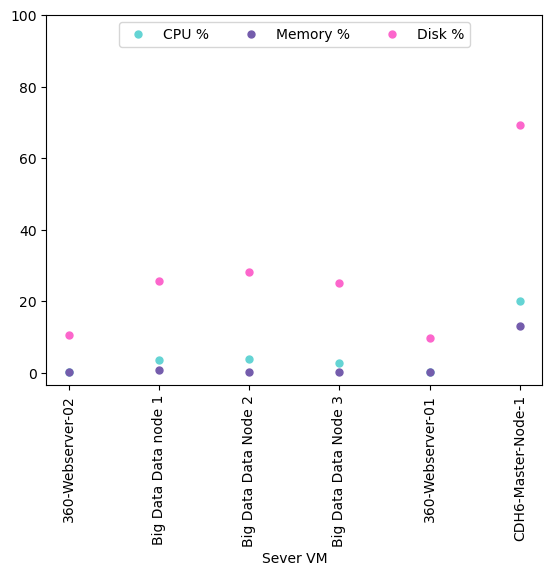

In [92]:
#-----------------  monthly trend chart -------------------#
df_avg_month = pd.concat([df_cpu_trend_avg_month, df_mem_trend_avg_month,df_disk_trend_avg_month], ignore_index=True)

groups = df_avg_month.groupby('label')

# Plot
fig, ax = plt.subplots()

colors = {"cpu_trend_avg_month": '#64d4d4', "mem_trend_avg_month": '#fc66cc',"disk_trend_avg_month": '#745cac'}
for name, group in groups:
    ax.plot(group.host_name, group.mean_value, marker='o', linestyle='', ms=5, label=name , c= colors[name])

legend_labels = ['CPU %', 'Memory %', 'Disk %'] # set legend
ax.legend(labels = legend_labels,loc='upper center',ncol=3) # add legend
plt.xticks(rotation=90)  # rotate text on x-axis to 90 degree
plt.xlabel("Sever VM") # add x label
plt.margins(x=0.05) # adds 5% padding to the autoscaling
plt.yticks(np.arange(0, 120, 20)) # set y-tick freq.
plt.show()

In [113]:
def text_status_th(percent):
    if percent > 85:
       text = "ระบบทำงานหนัก"
    elif percent < 75:
        text = "ปกติ"
    else: text = "ระบบมีความเสี่ยงสมควรเฝ้าระวัง"
    return text 

def text_status(percent):
    if percent > 85:
       text = "warning"
    elif percent < 75:
        text = "normal"
    else: text = "monitoring"
    return text 

df_avg_month["status"] = df_avg_month["mean_value"].apply(lambda x : text_status(x))
df_mem_trend_avg_month

df_cpu_trend_avg_month["status"] = df_cpu_trend_avg_month["mean_value"].apply(lambda x : text_status(x))
df_mem_trend_avg_month["status"] = df_mem_trend_avg_month["mean_value"].apply(lambda x : text_status(x))
#df_mem_trend_avg_month["status"] = ["normal", "normal", "monitoring", "warning","normal","monitoring",] # for testing
df_disk_trend_avg_month["status"] = df_disk_trend_avg_month["mean_value"].apply(lambda x : text_status(x))


In [125]:
def text_status_th(percent):
    if percent > 85:
       text = "ระบบทำงานหนัก"
    elif percent < 75:
        text = "ปกติ"
    else: text = "ระบบมีความเสี่ยงสมควรเฝ้าระวัง"
    return text 

def text_status(percent):
    if percent > 85:
       text = "warning"
    elif percent < 75:
        text = "normal"
    else: text = "monitoring"
    return text 

#-----------------  add status -------------------#
df_cpu_trend_avg_month["status"] = df_cpu_trend_avg_month["mean_value"].apply(lambda x : text_status(x))
df_mem_trend_avg_month["status"] = df_mem_trend_avg_month["mean_value"].apply(lambda x : text_status(x))
#df_mem_trend_avg_month["status"] = ["normal", "normal", "monitoring", "warning","normal","monitoring",] # for testing
df_disk_trend_avg_month["status"] = df_disk_trend_avg_month["mean_value"].apply(lambda x : text_status(x))


#-----------------  overall utilizaiton -------------------#
lst = []
dictt = {}

dictt["vm_total"] = len(df_cpu_trend_avg_month)

if len(df_cpu_trend_avg_month[df_cpu_trend_avg_month["status"] == "warning"]) != 0:
    dictt["cpu_warning"] = len(df_cpu_trend_avg_month[df_cpu_trend_avg_month["status"] == "warning"])
elif len(df_cpu_trend_avg_month[df_cpu_trend_avg_month["status"] == "warning"]) != 0:
    dictt["cpu_monitoring"] = len(df_cpu_trend_avg_month[df_cpu_trend_avg_month["status"] == "warning"])
else:
    dictt["cpu_monitoring"] = 0

if len(df_mem_trend_avg_month[df_mem_trend_avg_month["status"] == "warning"]) != 0:
    dictt["mem_warning"] = len(df_mem_trend_avg_month[df_mem_trend_avg_month["status"] == "warning"])
elif len(df_mem_trend_avg_month[df_mem_trend_avg_month["status"] == "warning"]) != 0:
    dictt["mem_monitoring"] = len(df_mem_trend_avg_month[df_mem_trend_avg_month["status"] == "warning"])
else:
    dictt["mem_monitoring"] = 0

if len(df_disk_trend_avg_month[df_disk_trend_avg_month["status"] == "warning"]) != 0:
    dictt["disk_warning"] = len(df_disk_trend_avg_month[df_disk_trend_avg_month["status"] == "warning"])
elif len(df_disk_trend_avg_month[df_disk_trend_avg_month["status"] == "warning"]) != 0:
    dictt["disk_monitoring"] = len(df_disk_trend_avg_month[df_disk_trend_avg_month["status"] == "warning"])
else:
    dictt["disk_monitoring"] = 0



lst.append(dictt)
lst

[{'vm_total': 6, 'cpu_monitoring': 0, 'mem_warning': 1, 'disk_monitoring': 0}]

In [ ]:
#-----------------  analysis result-------------------#